In [1]:
import sys, os, re, csv, codecs, numpy as np, pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Dense, Input, LSTM, Embedding, Dropout, Activation
from keras.layers import Bidirectional, GlobalMaxPool1D
from keras.models import Model
from keras import initializers, regularizers, constraints, optimizers, layers

Using TensorFlow backend.


In [2]:
train = pd.read_csv('../input/train.csv')
test = pd.read_csv('../input/test.csv')

In [3]:
train.head()


,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


In [4]:
train.isnull().any(),test.isnull().any()


(id               False
 comment_text     False
 toxic            False
 severe_toxic     False
 obscene          False
 threat           False
 insult           False
 identity_hate    False
 dtype: bool, id              False
 comment_text    False
 dtype: bool)

In [5]:
list_classes = ["toxic", "severe_toxic", "obscene", "threat", "insult", "identity_hate"]
y = train[list_classes].values
list_sentences_train = train["comment_text"]
list_sentences_test = test["comment_text"]


In [6]:
max_features = 20000
tokenizer = Tokenizer(num_words=max_features)
tokenizer.fit_on_texts(list(list_sentences_train))
list_tokenized_train = tokenizer.texts_to_sequences(list_sentences_train)
list_tokenized_test = tokenizer.texts_to_sequences(list_sentences_test)

In [7]:
list_tokenized_train[:1]


[[688,
  75,
  1,
  126,
  130,
  177,
  29,
  672,
  4511,
  12052,
  1116,
  86,
  331,
  51,
  2278,
  11448,
  50,
  6864,
  15,
  60,
  2756,
  148,
  7,
  2937,
  34,
  117,
  1221,
  15190,
  2825,
  4,
  45,
  59,
  244,
  1,
  365,
  31,
  1,
  38,
  27,
  143,
  73,
  3462,
  89,
  3085,
  4583,
  2273,
  985]]

In [8]:
maxlen = 200
X_t = pad_sequences(list_tokenized_train, maxlen=maxlen)
X_te = pad_sequences(list_tokenized_test, maxlen=maxlen)

In [9]:
totalNumWords = [len(one_comment) for one_comment in list_tokenized_train]


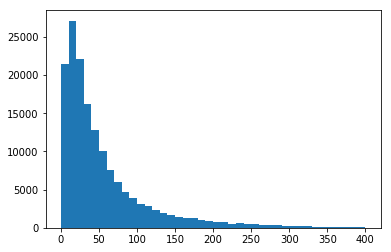

In [10]:
plt.hist(totalNumWords,bins = np.arange(0,410,10))#[0,50,100,150,200,250,300,350,400])#,450,500,550,600,650,700,750,800,850,900])
plt.show()

In [11]:
inp = Input(shape=(maxlen, )) #maxlen=200 as defined earlier


In [12]:
embed_size = 128
x = Embedding(max_features, embed_size)(inp)

In [13]:
x = LSTM(60, return_sequences=True,name='lstm_layer')(x)

x = GlobalMaxPool1D()(x)

x = Dropout(0.1)(x)

x = Dense(50, activation="relu")(x)

x = Dropout(0.1)(x)

x = Dense(6, activation="sigmoid")(x)

model = Model(inputs=inp, outputs=x)
model.compile(loss='binary_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])

model.summary()


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 200)               0         
_________________________________________________________________
embedding_1 (Embedding)      (None, 200, 128)          2560000   
_________________________________________________________________
lstm_layer (LSTM)            (None, 200, 60)           45360     
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 60)                0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 60)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 50)                3050      
_________________________________________________________________
dropout_2 (Dropout)          (None, 50)                0         
__________

In [14]:
batch_size = 32
epochs = 4
model.fit(X_t,y, batch_size=batch_size, epochs=epochs, validation_split=0.1)

Train on 143613 samples, validate on 15958 samples
Epoch 1/4
143613/143613 [==============================] - 1261s 9ms/step - loss: 0.0672 - acc: 0.9784 - val_loss: 0.0493 - val_acc: 0.9819
Epoch 2/4
143613/143613 [==============================] - 1250s 9ms/step - loss: 0.0444 - acc: 0.9832 - val_loss: 0.0468 - val_acc: 0.9827
Epoch 3/4
143613/143613 [==============================] - 1247s 9ms/step - loss: 0.0388 - acc: 0.9847 - val_loss: 0.0462 - val_acc: 0.9827
Epoch 4/4
143613/143613 [==============================] - 1246s 9ms/step - loss: 0.0343 - acc: 0.9863 - val_loss: 0.0484 - val_acc: 0.9822


In [16]:
def toxicity_level(string):
    """
    Return toxicity probability based on inputed string.
    """
    # Process string
    new_string = [string]
    new_string = tokenizer.texts_to_sequences(new_string)
    new_string = pad_sequences(new_string, maxlen=200, padding='post', truncating='post')
    
    # Predict
    prediction = model.predict(new_string)
    
    # Print output
    print("Toxicity levels for '{}':".format(string))
    print('Toxic:         {:.0%}'.format(prediction[0][0]))
    print('Severe Toxic:  {:.0%}'.format(prediction[0][1]))
    print('Obscene:       {:.0%}'.format(prediction[0][2]))
    print('Threat:        {:.0%}'.format(prediction[0][3]))
    print('Insult:        {:.0%}'.format(prediction[0][4]))
    print('Identity Hate: {:.0%}'.format(prediction[0][5]))
    print()
    
    return

toxicity_level('go jump off a bridge jerk')
toxicity_level('i will kill you')
toxicity_level('have a nice day')
toxicity_level('hola, como estas')
toxicity_level('hola mierda joder')
toxicity_level('fuck off!!')

Toxicity levels for 'go jump off a bridge jerk':
Toxic:         100%
Severe Toxic:  17%
Obscene:       92%
Threat:        0%
Insult:        93%
Identity Hate: 7%

Toxicity levels for 'i will kill you':
Toxic:         96%
Severe Toxic:  31%
Obscene:       36%
Threat:        47%
Insult:        39%
Identity Hate: 54%

Toxicity levels for 'have a nice day':
Toxic:         11%
Severe Toxic:  0%
Obscene:       3%
Threat:        1%
Insult:        2%
Identity Hate: 1%

Toxicity levels for 'hola, como estas':
Toxic:         1%
Severe Toxic:  0%
Obscene:       0%
Threat:        0%
Insult:        0%
Identity Hate: 0%

Toxicity levels for 'hola mierda joder':
Toxic:         2%
Severe Toxic:  0%
Obscene:       1%
Threat:        0%
Insult:        0%
Identity Hate: 0%

Toxicity levels for 'fuck off!!':
Toxic:         100%
Severe Toxic:  62%
Obscene:       100%
Threat:        1%
Insult:        84%
Identity Hate: 7%



In [17]:
all_losses = {
'cnn_loss': [0.0788,
  0.0574,
  0.0513,
  0.0476],
 'cnn_val_loss': [0.0562,
  0.0502,
  0.0510,
  0.0498],
 'baseline_loss': [0.0533,
  0.0444,
  0.0391,
  0.0343],
 'baseline_val_loss': [0.0490,
  0.0473,
  0.0476,
  0.0501]
}

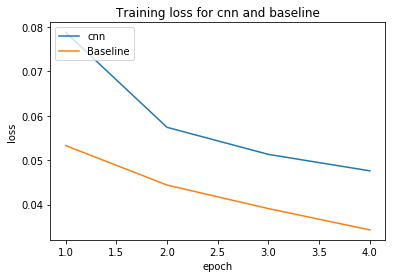

In [18]:
epochRange = np.arange(1,5,1)
plt.plot(epochRange,all_losses['cnn_loss'])
plt.plot(epochRange,all_losses['baseline_loss'])
plt.title('Training loss for cnn and baseline')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['cnn', 'Baseline'], loc='upper left')
plt.show()

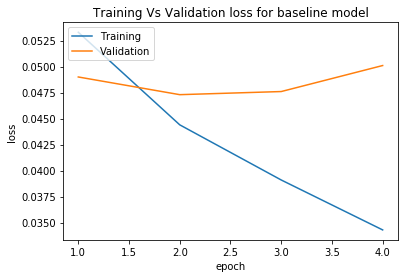

In [19]:
epochRange = np.arange(1,5,1)
plt.plot(epochRange,all_losses['baseline_loss'])
plt.plot(epochRange,all_losses['baseline_val_loss'])
plt.title('Training Vs Validation loss for baseline model')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['Training', 'Validation'], loc='upper left')
plt.show()

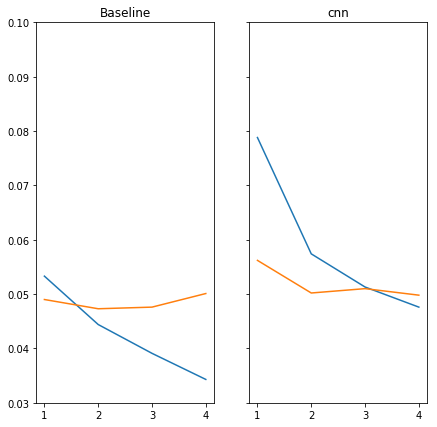

In [20]:
f, ((ax1, ax2)) = plt.subplots(1, 2, sharex='col', sharey='row',figsize=(7, 7))

plt.title('Training Vs Validation loss cnn vs baseline model')
ax1.plot(epochRange,all_losses['baseline_loss'])
ax1.plot(epochRange,all_losses['baseline_val_loss'])
ax1.set_title('Baseline')
ax1.set_ylim(0.03, 0.10)

ax2.plot(epochRange,all_losses['cnn_loss'])
ax2.plot(epochRange,all_losses['cnn_val_loss'])
ax2.set_title('cnn')
ax2.set_ylim(0.03, 0.10)

plt.show()